In [2]:
import pickle 
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as linalg
import scipy.sparse  
import networkx as nx

In [3]:
file_training_data = open('data-challenge-kernel-methods-2022-2023\\training_data.pkl', 'rb')
file_training_labels = open('data-challenge-kernel-methods-2022-2023\\training_labels.pkl', 'rb')

# dump information to that file
data = pickle.load(file_training_data)
labels = pickle.load(file_training_labels)

# close the file
file_training_data.close()
file_training_labels.close()

In [4]:
file_test_data = open('data-challenge-kernel-methods-2022-2023\\test_data.pkl', 'rb')

# dump information to that file
data_test = pickle.load(file_test_data)


# close the file
file_test_data.close()

# Preprocessing 

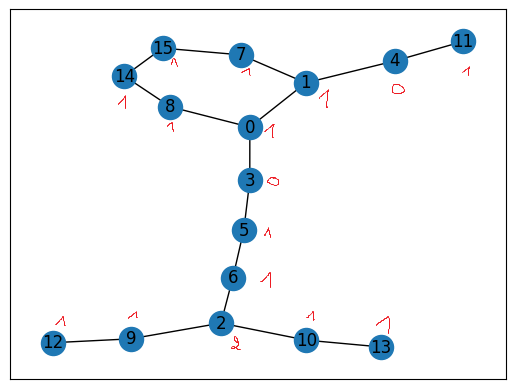

Les noeuds sont labelisés par un entier et les liasons [0,1,2,3]

In [6]:
data[0].nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15))

In [10]:
def edge_subg(subgraph):
    liste = list()
    for i in range(1,len(subgraph)):
        liste.append((subgraph[i-1], subgraph[i]))
        liste.append((subgraph[i], subgraph[i-1]))
    return liste

In [11]:
def Subgraph(Graph,n):
    all_subgraphs=dict({})
    if n>=1:
        all_subgraphs[1]=list()
        
        for node in Graph.nodes: #taille 1
            all_subgraphs[1].append(tuple( (node,) ) )
            
    if n>=2:
        all_subgraphs[2] = list()
        for edge in Graph.edges:
            all_subgraphs[2].append(edge)
            
    for k in range(3,n+1):
        all_subgraphs[k] = list()
        for subgraph in all_subgraphs[k-1]:
            for edge in Graph.edges : 

                if edge in edge_subg(subgraph):
                    break 

                if subgraph[0] == edge[0]:
                    all_subgraphs[k].append(tuple ( [edge[1]]+list(subgraph)))

                if subgraph[0] == edge[1]:
                    all_subgraphs[k].append(tuple ( [edge[0]]+list(subgraph)))

                if subgraph[-1] == edge[1]:
                    all_subgraphs[k].append(tuple ( list(subgraph) +[edge[0]]))

                if subgraph[-1] == edge[0]:
                    all_subgraphs[k].append(tuple ( list(subgraph) +[edge[1]]))
                    
    return all_subgraphs
        

In [18]:
path_dict = Subgraph(data[0],5)
print("All the paths present in the first molecule of the dataset is:\n")
for key in path_dict.keys():
    print(f'     -  Size {key} : ', path_dict[key])

All the paths present in the first molecule of the dataset is:

     -  Size 1 :  [(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,)]
     -  Size 2 :  [(0, 1), (0, 3), (0, 8), (1, 4), (1, 7), (2, 6), (2, 9), (2, 10), (3, 5), (4, 11), (5, 6), (7, 15), (8, 14), (9, 12), (10, 13), (14, 15)]
     -  Size 3 :  [(1, 0, 3), (1, 0, 8), (3, 0, 8), (0, 1, 4), (0, 1, 7), (4, 1, 7), (6, 2, 9), (6, 2, 10), (9, 2, 10), (0, 3, 5), (1, 4, 11), (5, 6, 2), (3, 5, 6), (1, 7, 15), (0, 8, 14), (2, 9, 12), (2, 10, 13), (14, 15, 7), (8, 14, 15)]
     -  Size 4 :  [(1, 0, 3, 5), (0, 1, 4, 11), (0, 3, 5, 6), (3, 5, 6, 2), (0, 1, 7, 15), (4, 1, 7, 15), (1, 0, 8, 14), (3, 0, 8, 14), (6, 2, 9, 12), (6, 2, 10, 13), (9, 2, 10, 13), (14, 15, 7, 1), (0, 8, 14, 15), (8, 14, 15, 7)]
     -  Size 5 :  [(1, 0, 3, 5, 6), (0, 3, 5, 6, 2), (14, 15, 7, 1, 0), (14, 15, 7, 1, 4), (1, 0, 8, 14, 15), (3, 0, 8, 14, 15), (0, 8, 14, 15, 7), (8, 14, 15, 7, 1)]


In [19]:
alphabet='A B C D E F G H I J K L M N O P Q R S T U V W X Y Z a b c d e f g h i j k l m n o p q r s t u v w x y z'.split()
def from_nodes_to_atoms_and_bonds(Graph,tup):
    #print((Graph.nodes[tup[0]])['labels'][0])
    char= alphabet [ (Graph.nodes[tup[0]])['labels'][0] ]
    #print(char)
    for i in range(1,len(tup)):
        try :
            char+= str((Graph.edges[(tup[i-1],tup[i])])['labels'][0])
        except KeyError:
            raise TypeError ('Your tup is not a subgraph')
        #print('here', (Graph.edges[(tup[i-1],tup[i])])['labels'][0])
        char+=alphabet [ (Graph.nodes[tup[i]])['labels'][0] ]
        #print('there', (Graph.nodes[tup[i]])['labels'][0] )
    
    if tup[0]==tup[-1] and len(tup)>2: #it is a cycle 
        return 'cyc_'+char+'_cyc'
        
    return char

In [23]:
print("In molecule 1, the path (0, 1, 4, 11) gets converted to", from_nodes_to_atoms_and_bonds(data[0],(0, 1, 4, 11)),'.')
print('This string chain represents atoms and bonds present in the molecule independently on the indexing of nodes. ')

In molecule 1, the path (0, 1, 4, 11) gets converted to B2B0A0B .
This string chain represents atoms and bonds present in the molecule independently on the indexing of nodes. 


In [24]:
def from_Graph_to_vector(Graph, n):
    all_subgraphs = Subgraph(Graph,n)
    
    all_char = {i: [from_nodes_to_atoms_and_bonds(Graph,tup) for tup in all_subgraphs[i]] for i in all_subgraphs.keys()}
    
    counter = dict({})
    for i in range(1,n+1):
        for char in all_char[i]:
            if 'cyc' in char.split('_'):
                char_ = char
                char__ = char.split('_')[1] #on garde le milieu 
                #print('le départ est ici')
                #la taille est i, il y a i atomes
                for permutation in range(i-1):
                    #print(char_)
                    if char_ in counter.keys() :
                        counter[char_]+= 1 #+=1 one hot_encoding
                        break
                    elif char_[::-1] in counter.keys() : 
                        counter[char_[::-1]]+= 1 #+=1 one hot encoding
                        break
                        
                    char__= char__[-3:-1]+char__[:-2] #effectue un permutation
                    char_ = 'cyc_'+char__+'_cyc'
                    
                    if permutation ==i-2: #le cycle n'a pas été trouvé
                        counter[char]=1
            
            
            else:
                if char in counter.keys() :
                    counter[char]+= 1 #+=1 one hot_encoding
                elif char[::-1] in counter.keys() : 
                    counter[char[::-1]]+= 1 #+=1 one hot encoding 
                else :
                    counter[char]=1
                
    return counter

In [25]:
print("In molecule 1, the present path in terms of type of atoms and bonds are :\n", from_Graph_to_vector(data[0], 5))

In molecule 1, the present path in terms of type of atoms and bonds are :
 {'B': 13, 'C': 1, 'A': 2, 'B2B': 6, 'B0A': 4, 'C0B': 3, 'B0B': 3, 'B2B0A': 4, 'B2B2B': 6, 'B0C0B': 3, 'B0A0B': 2, 'B0B0C': 3, 'A0B0B': 1, 'B2B0A0B': 2, 'B0A0B0B': 1, 'A0B0B0C': 1, 'B2B2B2B': 5, 'A0B2B2B': 2, 'B0C0B0B': 3, 'B2B0A0B0B': 1, 'B0A0B0B0C': 1, 'B2B2B2B2B': 4, 'B2B2B2B0A': 2}


In [26]:
from tqdm import tqdm

In [27]:
data_vector=list()
for i in tqdm(range(len(data))):
    data_vector.append( from_Graph_to_vector(data[i], 5) )
data_vector = np.array(data_vector, dtype = dict)

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:08<00:00, 670.81it/s]


In [28]:
data_test_vector=list()
for i in tqdm(range(len(data_test))):
    data_test_vector.append( from_Graph_to_vector(data_test[i], 5) )
data_test_vector = np.array( data_test_vector, dtype = dict)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 314.63it/s]


The preprocessing is done. 

# Compute Kernel

In [29]:
def k_min_max(vec1,vec2):
    'définis le kernel min_max, ici la somme est sur les sousgraphes, on ajoute 0 si le sousgraphe est présent dans aucun des graphes'
    #produit_scalaire = 0
    min_sum = 0
    max_sum = 0
    for char in union_keys(vec1.keys(),vec2.keys()):
        
        
        if in_keys(char, vec1):
            if in_keys(char, vec2):
                ##char present in the two graph
                
                min_sum += min( reversable_indexing(vec1, char),reversable_indexing(vec2, char) )
                max_sum += max( reversable_indexing(vec1, char),reversable_indexing(vec2, char) )
                
            else:
                ##char present in the graph 1, but in graph 2
                max_sum += reversable_indexing(vec1, char)
        
        else:
            if in_keys(char, vec2):
                ##char present in the graph 2, but in graph 1
                max_sum += reversable_indexing(vec2, char)
                
            else :
                ##char not present in any graph
                print('you are not supposed to go in this case')
                

    ## dans les autres cas, on rajoute 0
    if max_sum==0:
        return 0
    #print(min_sum, max_sum)
    
    return min_sum/max_sum
        

In [30]:
def in_keys(char, vec):
    if (char in vec.keys() or char[::-1] in vec.keys()):
        return True
    ##classique comme tout à l'heure
    if not('cyc' in char.split('_') ):
        return False
    ##on s'occupe du cas où il y a des cycles
    ##on va regarder si il y au moins une permutation de char dans le graphe
    char_ = char
    char__ = char.split('_')[1] #on garde le milieu 
    
    for permutation in range(((len(char)-8)//2)+1):
        #print(char_)
        if char_ in vec.keys() :
            return True
        elif char_[::-1] in vec.keys() : 
            return True

        char__= char__[-3:-1]+char__[:-2] #effectue un permutation
        char_ = 'cyc_'+char__+'_cyc'

    return False 

In [31]:
def reversable_indexing(vec, key):
    'this otputs the value of the equivalent key. Two keys are equivalent if they are reversed of one another.\
    For cycles, keys are equivalent if there exist a cyclic permutation that maps the first on the second one.'
    if key in vec.keys() and key[::-1] in vec.keys():
    
        #print('the key appears twice')
        if vec[key]==vec[key[::-1]]:
            return vec[key]
        else:
            raise NameError('A same index is mentionned twice and has different values')
            
    if key in vec.keys():
        return vec[key]
    if key[::-1] in vec.keys():
        return vec[key[::-1]]
    
    if 'cyc' in key.split('_') :
        char_ = key
        char__ = key.split('_')[1] #on garde le milieu 
    
        for permutation in range(((len(key)-8)//2)+3):
            #print(char_)
            if char_ in vec.keys() :
                return vec[char_]
            elif char_[::-1] in vec.keys() : 
                return vec[char_[::-1]]

            char__= char__[-3:-1]+char__[:-2] #effectue un permutation
            char_ = 'cyc_'+char__+'_cyc'
    
    raise KeyError ('The input key is not in the vector keys ')
    
    

In [32]:
def union_keys(keys1,keys2):
    set_ = set( keys1 ).union( set(  keys2 ) )
    #print(set_)
    set_final = list()
    for element in set_:
        if not(element in set_final) and not(element[::-1] in set_final):
            set_final.append(element)
    return set_final

Here a small example of computation $k(G_1,G_2)$.

In [33]:
vec1 = dict({ 'bc':1,'bcd':1, 'u':1, 'c1b0a':2, 'cyc_A0B0C0D0A_cyc':1})
vec2 = dict({'c1b0a':1, 'cb':1,'bcd':1, 'ko':7, 'cyc_B0C0D0A0B_cyc':2})
k_min_max(vec1,vec2)

0.3125

# Compute Gramm Matrix and SVM

In [34]:
## we use our implementation of svm from assignment 2
from svm import KernelSVC

In [35]:
from time import time 

In [36]:
def kernel(X,Y,same=False):
    if same == True:
        a = np.zeros((len(X), len(Y)))
        for i in range(len(X)):
            for j in range(i+1):
                a[i,j] = k_min_max(X[i],Y[j])
        return a + a.T - np.diag(a.diagonal())
        
    return np.array([[k_min_max(x,y) for y in Y] for x in X])

In [184]:
from sklearn.model_selection import train_test_split

##on définit les sous-datasets sur lesquels on va faire nos entraînements et évaluations,
##le split dataset de train fait 1200 échantillons, le split test dataset fait 400 molécules
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(data_vector, labels, 
                                                    test_size=0.07, train_size=0.2,
                                                    random_state=22)

In [186]:
C=100.

model2 = KernelSVC(kernel=kernel,C=C)

#x_over_sample, y_over_sample = random_Oversample(X_train_split,y_train_split)
model2.fit(X_train_split, y_train_split) 
## 
##
#C=1, on avait aucun points en marge
#on regarde C=100

Start of the computation of the gramm matrix
End of the computation of the gramm matrix.
Temps écoulé 83.65727066993713 s
Start of the minimization of the cost function
End of the minimization.
Temps écoulé 620.1601438522339 s


In [ ]:
import pickle

# Garde en mémoire le modèle
with open('model.pkl', 'wb') as fichier:
    # Écrire l'objet dans le fichier
    pickle.dump(model2, fichier)

In [ ]:
print('Alpha =', model2.alpha)
print("On vérifie que les points ont bien été pris en compte lors du fit.\
        Il faut qu'une grande partie des alpha soit entre 0 et C")

In [187]:
from sklearn.metrics import  roc_auc_score 
y_pred = model2.predict(X_test_split)

# Evaluate the predictions
print("Area Under Curve:", roc_auc_score(y_pred, y_test_split))


Area Under Curve: 0.7295758051846033


In [188]:
y_submission = model2.predict(data_test_vector)

In [189]:
import csv

# ouvrir le fichier CSV en écriture
with open('test_pred.csv.csv', mode='w', newline='') as file:
    # créer un objet writer
    writer = csv.writer(file)
    
    # écrire l'en-tête du fichier CSV
    writer.writerow(['ID', 'Predicted'])
    
    # écrire les données
    for i in range(len(data_test)):
        writer.writerow([i+1, y_submission[i]])

## Annexe :

Functions to make the dataset balanced. 

In [36]:
#@title OverSampling and Undersampling

import random
from sklearn.utils import shuffle
def random_Oversample(X,y):
    X0 = X[y_train_split==0]
    X1 = X[y_train_split==1] 
    indices = [random.randint(0,len(X1) -1) for i in range(len(X0))]
    X_conc = np.concatenate([X0,X1[indices] ], axis=0)
    indices_shuffle = shuffle( list(range(len(X_conc))) )

    return X_conc[indices_shuffle], np.array([0]*len(X0)+[1]*len(X0))[indices_shuffle]
#print(indices_shuffle)

def random_Undersample(X,y):
    X0 = X[y_train_split==0]
    X1 = X[y_train_split==1] 
    indices = [random.randint(0,len(X0) -1) for i in range(len(X1))]
    X_conc = np.concatenate([X0[indices],X1 ], axis=0)
    indices_shuffle = shuffle( list(range(len(X_conc))) )

    return X_conc[indices_shuffle], np.array([0]*len(X1)+[1]*len(X1))[indices_shuffle]